## Modeling and Model Evaluation: Using `Pipelines`, `TfidVectorizer`, `GridSearchCV`, and `LogisticRegression`.
*citation:* GA Lesson 6.03, 6.04, and 6.05

In this analysis, I will utilize a robust approach to model and predict text data. Initially, I will set up a Pipeline integrating TfidfVectorizer and LogisticRegression, and then fine-tune their parameters using GridSearchCV.

Like before, I will be implementing a custom preprocessor in TfidfVectorizer.

It is important to acknowledge that Logistic Regression assumes observations are independent of each other. This is important to note, as text data often has contextual dependencies that affect the overall meaning.

To comprehensively evaluate the model's performance, I will analyze a range of metrics, including a Confusion Matrix, Specificity, Precision, Sensitivity, and F1 scores, in addition to accuracy scores. These metrics will provide valuable insights into the model's ability to accurately classify text data.

#### Importing libraries, reading in data, and binarizing the target variable

In [24]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn import metrics
import re

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
# Reading in data
df = pd.read_csv('./Data/clean_posts')

In [4]:
# Binarizing the target variable
df['source'] = df['source'].map({'AmItheAsshole': 1, 'AskLawyers' : 0})

---
#### Declaring a feature matrix, X, and target variable, y.
Then splitting the data frame in to training data & testing data.


In [5]:
# variables
X = df['post']
y = df['source']

# Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

#### Baseline Accuracy
Determining the baseline accuracy to determine if my model is better than null model (predicting the plurality class)

In [6]:
baseline =y_train.value_counts(normalize = True)
baseline

source
1    0.719944
0    0.280056
Name: proportion, dtype: float64

**Interpretation:** if we predict the post came from AITA, we'll be right ~72% of the time.

---
#### Defining my custom pre-processor.

In [7]:
def remove_urls_emojis(post):
    # remove URLs
    url_exp = re.compile(r'https?://\S+|www\.\S+') #find URLs
    post = url_exp.sub('', post) #replace w/ an empty string

    # remove Emojis
    emoji_exp = re.compile('['
        u'\U0001F300-\U0001F5FF'
        u'\U0001F600-\U0001F64F'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F700-\U0001F77F'
        u'\U0001F780-\U0001F7FF'
        u'\U0001F800-\U0001F8FF'
        u'\U0001F900-\U0001F9FF'
        u'\U0001FA00-\U0001FA6F'
        u'\U0001FA70-\U0001FAFF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    post = emoji_exp.sub('', post)
    
    # remove special characters
    post = re.sub(r'[^a-zA-Z0-9\s]', '', post)
    
    return post

In [16]:
# Instantiate the transformer.
tvec = TfidfVectorizer()

---
#### Setting a 2 stage `Pipeline`

In [17]:
# Declaring a Pipeline, and introducing my preprocessing function.
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(preprocessor = remove_urls_emojis)), 
    ('lr', LogisticRegression()) 
    
])

---
#### GridSearchCV
Since I want to tune over the `TfidVectorizer`, I will load the `Pipeline` object into `GridSearchCV`.

In [21]:
# Search over the following values of hyperparameters:
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000], 
    'tvec__min_df': [2, 4, 6], 
    'tvec__max_df': [0.95, 0.97, 0.99],
    'tvec__ngram_range': [(1, 1), (1,2), (1,3)] 
                 }

In [22]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(pipe_tvec,
                      param_grid = pipe_tvec_params,
                      cv = 5,
                      n_jobs = -1)


In [25]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(preprocessor=<function remove_urls_emojis at 0x17d7ae8e0>)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.95, 0.97, 0.99],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 4, 6],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [26]:
print('\033[1mBaseline Accuracy Score:\033[1m', baseline, '\n')
print('\033[1mBest Accuracy Score on cross validation:\033[0m', gs_tvec.best_score_, '\n')
print('\033[1mBest Accuracy Score on training data:\033[0m', gs_tvec.score(X_train, y_train), '\n')
print('\033[1mBest Accuracy Score on testing data:\033[0m', gs_tvec.score(X_test, y_test), '\n')
print('\033[1mBest Parameters found by GridSearchCV:\033[0m', '\n', gs_tvec.best_params_)

Baseline Accuracy Score: source
1    0.719944
0    0.280056
Name: proportion, dtype: float64 

Best Accuracy Score on cross validation: 0.9346689895470384 

Best Accuracy Score on training data: 0.9645587213342599 

Best Accuracy Score on testing data: 0.9478873239436619 

Best Parameters found by GridSearchCV: 
 {'tvec__max_df': 0.95, 'tvec__max_features': 2000, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 1)}


**Interpretation & notes:**
* Like the cvec-mb model (CountVectorizer-MultinomialBayes model), this model demonstrates a considerable improvement over the baseline accuracy, indicating its effectiveness in classification tasks. Like before, the testing and training accuracy scores suggest some level of overfitting. However, this discrepancy is minimal, suggesting that the model generalizes reasonably well to unseen data.

* Comparing the models, we can see the cvec-mb model accuracy score is lower. Interestlingly, the GridSearchCV optimized for the same max_df, min_df, and ngram_range. The max_features were drastically different.

| Model                              | Baseline Accuracy (Source 1: AmItheAssole) | Baseline Accuracy (Source 0: AskLawyers) | Best Accuracy Score (CV) | Best Accuracy Score (Training) | Best Accuracy Score (Testing) | Best Parameters Found                             |
|------------------------------------|------------------------------------|------------------------------------|--------------------------|--------------------------------|-------------------------------|--------------------------------------------------|
| CountVectorizer + MultinomialNB    | 0.719944                           | 0.280056                           | 0.964564                 | 0.979847                       | 0.950704                      | max_df': 0.95, 'max_features': 5000, 'min_df': 4, 'ngram_range': (1, 1) |
| TfidVectorizer + LinearRegression | 0.719944                           | 0.280056                           | 0.934669                 | 0.964559                       | 0.947887                      | 'max_df': 0.95, 'max_features': 2000, 'min_df': 4, 'ngram_range': (1, 1) |

* While accuracy is a valuable metric for assessing model performance, it should not be considered in isolation. Additional metrics such as precision, recall, and F1-score provide deeper insights into the model's predictive capabilities.

Below, I'll present key metrics, including true positives, false positives, true negatives, and false negatives. These metrics are essential for a comprehensive evaluation of the model's performance. Additionally, I will analize the model's performance using an ROC and AUC. 

#### Evaluating the model using a Confusion Matrix

In [28]:
# Get predictions
preds = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

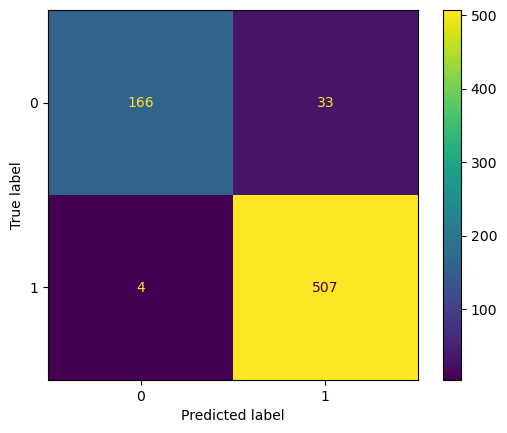

In [30]:
# View confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds),
                             display_labels=gs_tvec.classes_)
disp.plot();

# Saving Figure to Images folder
plt.savefig('./Images/conf_matrix_tvec_lr')

**Calculating Metrics other than accuracy**

In [32]:
specificity =  tn / (tn + fp)
print('Specificity Score: ', specificity)
print('Recall Score: ', metrics.recall_score(y_test, preds))
print('Precision Score: ', metrics.precision_score(y_test, preds))
print('F1 Score: ', metrics.f1_score(y_test, preds))

Specificity Score:  0.8341708542713567
Recall Score:  0.9921722113502935
Precision Score:  0.9388888888888889
F1 Score:  0.9647954329210277


| Metric          | Score            |
|-----------------|------------------|
| Specificity     | 0.8341708542713567 |
| Recall          | 0.9921722113502935 |
| Precision       | 0.9388888888888889 |
| F1 Score        | 0.9647954329210277 |


**Interpretation of the calculated metrics:**

*citation:* [towardsdatascience.com]('https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9')

* **Recall,** also known as sensitivity or true positive rate, represents the proportion of correctly predicted posts from a specific source out of all the posts that were from that source. A high recall score means we have minimized the number of false negatives. The model's recall score of 0.99 means the model correctly identifies the percentage of the posts that were truly from source 0.


* **Precision** is a good measure to determine, when the costs of False Positive is high. A high precision score indicates that when the model predicts a post to be from source 1, it is usually correct.
  
* **F1 scores**, also known as the harmonic mean, are a particularly helpful metric as they are a function of both recall and precision. A high F1 score tells us the model has high precision and high recall. This means the model is identifying the source correctly and minimizing misclassifications.

* **Specificity** represents the ability of the model to correctly identify posts from source 1 as being from source 1, relative to all the actual posts that are from source 1. A high specificity score indicates that the model has a strong ability to correctly identify posts from source 1, without mistakenly classifying too many posts from source 0 as being from source 1. This metric is particularly important when the cost of misclassifying posts from source 1 as source 0 is high.
  






#### Comparing metrics from my first model (`CountVectorizer` + `NaïveBayes`) to my second model (`TfidVectorizer` + `LogisticRegression`)

| Metric          | CountVectorizer + MultinomialNB | TfidVectorizer + LogisticRegression |
|-----------------|---------------------------------|-------------------------------------|
| Specificity     | 0.889                           | 0.834                               |
| Recall          | 0.975                           | 0.992                               |
| Precision       | 0.958                           | 0.939                               |
| F1 Score        | 0.966                           | 0.965                               |


Looking at the F1 Score, we see that both models perform really well and have almost identical metrics. This means they're both effective in making accurate predictions. When we also consider Specificity, Recall, and Precision, we find that although the models have some small differences, they both do a great job overall. So, whether we use TfidVectorizer with LogisticRegression or CountVectorizer with MultinomialNB, we can trust that our models are doing a solid job at predicting the source of the reddit posts.

Another important metric is the AUC for the ROC curve. I will calculate those below.

#### ROC curve and AUC
*citation:* [medium.com]('https://medium.com/@shaileydash/understanding-the-roc-and-auc-intuitively-31ca96445c02')

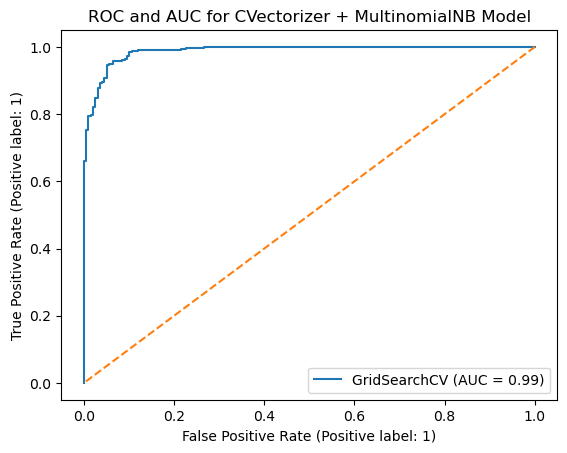

In [35]:
RocCurveDisplay.from_estimator(gs_tvec, X_test, y_test);

plt.title('ROC and AUC for CVectorizer + MultinomialNB Model')
plt.plot([1,0], [1,0], linestyle = '--')

# Saving Figure to Images folder
plt.savefig('./Images/roc_auc_cvec_lr')

**Interpretation & notes on ROC & AUC**

The ROC curve (Receiver Operating Characteristic curve) provides a visual insight into how well a binary classification model performs. Often considered the gold-standard.

The AUC (Area Under the Curve) for this model is 0.99, which is the same score as the previous model, indicating that both models effectively distinguishes posts from the target source. Ideally, a perfect AUC score of 1.0 would form an ROC curve with a 90° angle at the top left, signifying flawless performance.

The gold, dashed line is added to the graph to show the lowest performance a model could have when measured using this tool.

The model maintains a low false positive rate, meaning it rarely misclassifies posts from other sources as originating from the target source.